# Human Interpretable Deep Learning - Structured Data

Here we will look at ways to interpret deep learning models built and trained on tabular \ structured datasets

# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import model_evaluation_utils as meu
import matplotlib.pyplot as plt
from collections import Counter
import shap
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

# Load the Census Income Dataset

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


# Basic Feature Engineering

In [4]:
data = pd.get_dummies(data)
data.head()

,Age,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39.0,13.0,2174.0,0.0,40.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50.0,13.0,0.0,0.0,13.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38.0,9.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53.0,7.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28.0,13.0,0.0,0.0,40.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 91), (9769, 91))

# Build a Deep Learning Classification Model

In [6]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, BatchNormalization
from keras.optimizers import Adam

num_input_features = X_train.shape[1]

dnn_model = Sequential()
dnn_model.add(Dense(256, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))

dnn_model.add(Dense(128, kernel_initializer='glorot_uniform'))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))

dnn_model.add(Dense(64, kernel_initializer='glorot_uniform'))
dnn_model.add(BatchNormalization())
dnn_model.add(Activation('relu'))

dnn_model.add(Dense(1))
dnn_model.add(Activation('sigmoid'))

dnn_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=2e-5),                 
                  metrics=['accuracy'])
dnn_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               23552     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [7]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = dict(enumerate(class_weights))
class_weights[1] *= 2
class_weights

{0: 0.6600637127135824, 1: 4.123756106386828}

In [8]:
dnn_model.fit(X_train, y_train, batch_size=128, 
              epochs=100, validation_split=0.1, verbose=1, 
              class_weight=class_weights)

Train on 20512 samples, validate on 2280 samples
Epoch 1/100
20512/20512 [==============================] - 5s 231us/step - loss: 0.9322 - acc: 0.7600 - val_loss: 0.8915 - val_acc: 0.6474
Epoch 2/100
20512/20512 [==============================] - 4s 175us/step - loss: 0.8343 - acc: 0.6665 - val_loss: 0.8593 - val_acc: 0.6895
Epoch 3/100
20512/20512 [==============================] - 2s 106us/step - loss: 0.7826 - acc: 0.6505 - val_loss: 0.8635 - val_acc: 0.7776
Epoch 4/100
20512/20512 [==============================] - 3s 139us/step - loss: 0.7349 - acc: 0.6528 - val_loss: 0.8254 - val_acc: 0.7746
Epoch 5/100
20512/20512 [==============================] - 4s 174us/step - loss: 0.7000 - acc: 0.6411 - val_loss: 0.8057 - val_acc: 0.7728
Epoch 6/100
20512/20512 [==============================] - 5s 252us/step - loss: 0.6789 - acc: 0.6386 - val_loss: 0.8129 - val_acc: 0.8241
Epoch 7/100
20512/20512 [==============================] - 5s 250us/step - loss: 0.6581 - acc: 0.6512 - val_loss: 0.8

In [9]:
dnn_model.save('dnn_census.h5')

In [10]:
predictions = dnn_model.predict_classes(X_test, batch_size=512)

In [11]:
class_labels = [0, 1]
meu.display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8426
Precision: 0.8416
Recall: 0.8426
F1 Score: 0.8421

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      7455
           1       0.67      0.66      0.66      2314

    accuracy                           0.84      9769
   macro avg       0.78      0.78      0.78      9769
weighted avg       0.84      0.84      0.84      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6707   748
        1        790  1524


# Deep Learning Model Interpretation with Deep SHAP

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT.

### What is DeepLIFT?

The purported “black box” nature of neural networks is a barrier to adoption in applications where interpretability is essential. 

DeepLIFT (Deep Learning Important FeaTures), a method for decomposing the output prediction of a neural network on a specific input by backpropagating the contributions of all neurons in the network to every feature of the input. 

DeepLIFT compares the activation of each neuron to its ‘reference activation’ and assigns contribution scores according to the difference. 

By optionally giving separate consideration to positive and negative contributions, DeepLIFT can also reveal dependencies which are missed by other approaches. Scores can be computed efficiently in a single backward pass.


### How is Deep SHAP different?

The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. 

In [14]:
explainer = shap.DeepExplainer(dnn_model, data=X_train)

In [20]:
shap_values = explainer.shap_values(X_test.values)
shap_values = shap_values[0]
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,-0.048272,-0.016401,-0.039074,-0.028636,-0.014088,0.000287,-0.000687,0.001084,-2.119240e-06,0.000632,...,0.000003,0.000051,-1.526889e-06,0.000022,-4.611101e-07,0.000003,0.000005,0.001118,0.000041,-0.000004
1,0.055851,-0.060327,-0.023613,-0.017108,0.002891,0.001041,-0.001956,0.002522,-9.966023e-06,-0.005749,...,0.000017,0.000195,-6.876903e-06,0.000048,1.011429e-05,0.000013,0.000024,0.003656,0.000169,-0.000005
2,-0.063074,0.126537,-0.023904,-0.016973,0.052591,0.000982,-0.001777,0.002496,-9.248967e-06,0.002011,...,0.000024,0.000200,-6.355966e-06,0.000049,1.180774e-05,0.000013,0.000024,0.003611,0.000156,-0.000007
3,-0.041341,0.042329,-0.044460,-0.033685,-0.008815,0.000299,-0.000844,0.001275,-2.568942e-06,0.001165,...,0.000005,0.000065,-2.100089e-06,0.000023,2.160802e-06,0.000004,0.000007,0.001364,0.000051,-0.000005
4,-0.036544,-0.012499,-0.105341,-0.026677,0.024461,-0.000003,-0.000418,0.001033,-7.692337e-07,-0.003112,...,0.000011,0.000041,-6.895960e-07,0.000020,8.529965e-06,0.000004,0.000004,0.000696,0.000039,-0.000010


# Explaining Individual Predictions

In [22]:
print('Expected Value:', explainer.expected_value[0])

Expected Value: 0.30029738


In [38]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [45]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:])

In [46]:
shap.force_plot(explainer.expected_value, shap_values[:500,:], X_test.iloc[:500,:])

# Feature Importance Plots

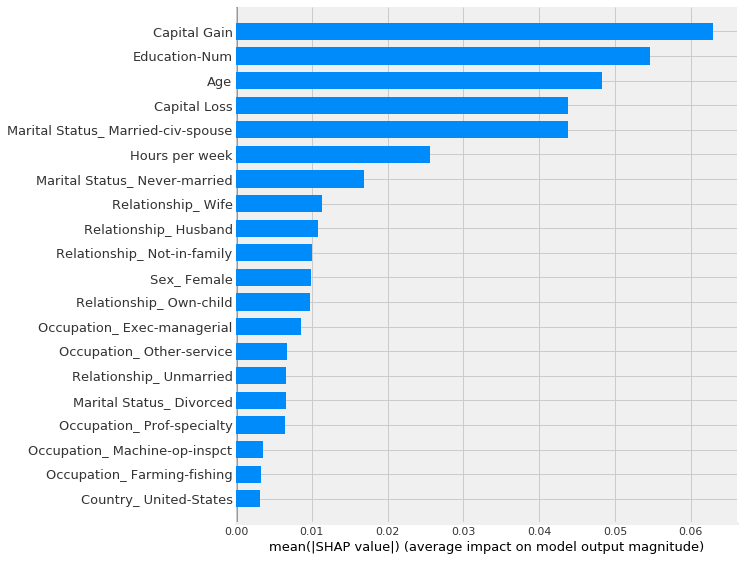

In [47]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

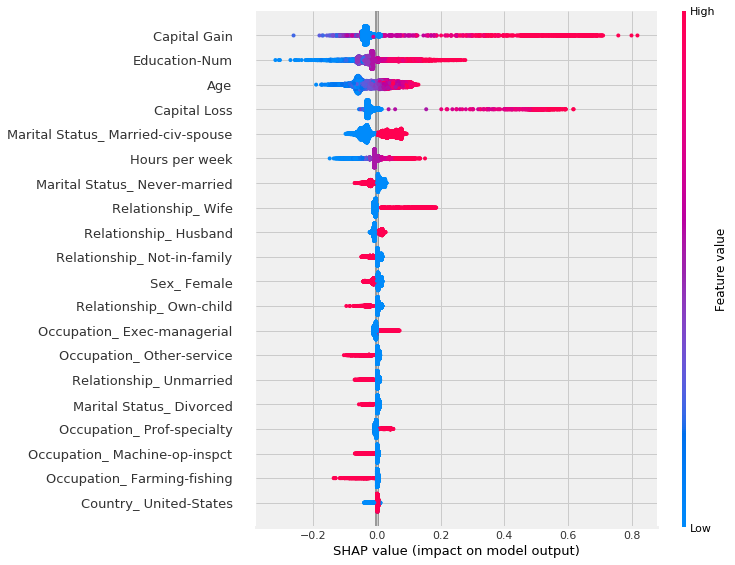

In [48]:
shap.summary_plot(shap_values, X_test)

# Partial Dependence Plots

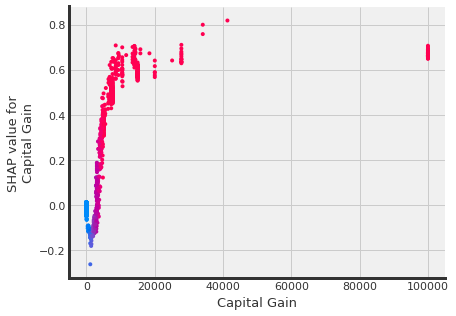

In [49]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

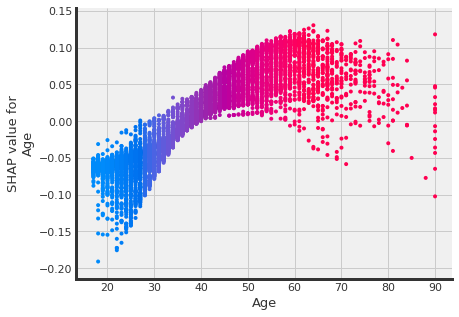

In [50]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

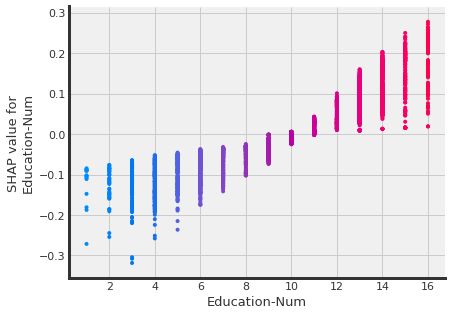

In [51]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

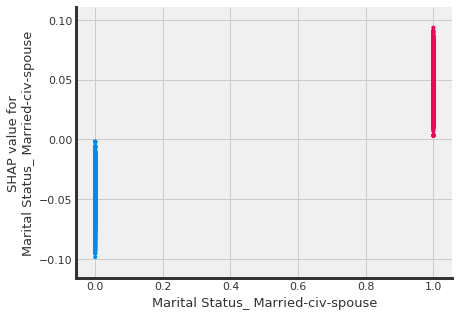

In [52]:
shap.dependence_plot(ind='Marital Status_ Married-civ-spouse', 
                     interaction_index='Marital Status_ Married-civ-spouse',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test)

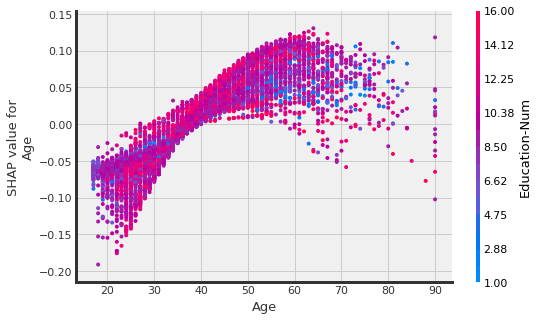

In [53]:
shap.dependence_plot(ind='Age', interaction_index='Education-Num', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

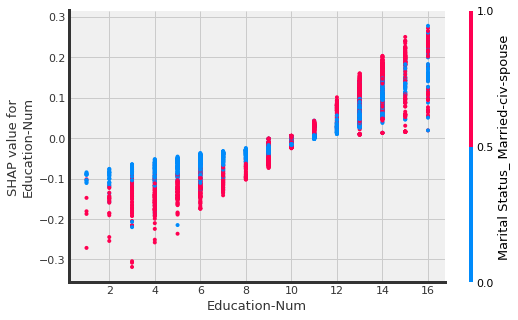

In [54]:
shap.dependence_plot(ind='Education-Num', interaction_index='Marital Status_ Married-civ-spouse', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)

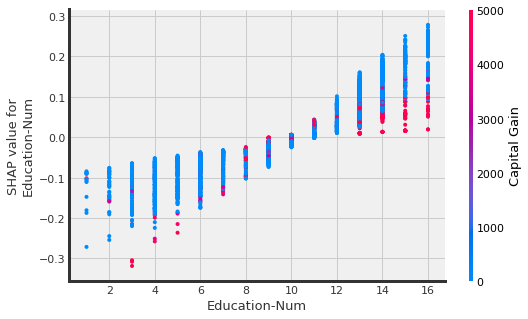

In [55]:
shap.dependence_plot(ind='Education-Num', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test)